## TensorFlow Regression Analysis

### Step 1: Obtain Dataset

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf

In [4]:
conn = sqlite3.connect("../db/stocks.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

cmd = '''
SELECT g.Date AS Date,
        g."Adj Close" AS GrowthStock_AdjClose,
        (g."Adj Close" - LAG(g."Adj Close", 1) OVER (ORDER BY g.Date))/ 
                LAG(g."Adj Close", 1) OVER (ORDER BY g.Date) AS GrowthStock_PercentChange,
        
        v."Adj Close" AS ValueStock_AdjClose,
        (v."Adj Close" - LAG(v."Adj Close", 1) OVER (ORDER BY g.Date))/ 
                LAG(v."Adj Close", 1) OVER (ORDER BY g.Date) AS ValueStock_PercentChange,
        
        t."Adj Close" AS Treasury10yr_AdjClose,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY g.Date))/ 
                LAG(t."Adj Close", 1) OVER (ORDER BY g.Date) AS Treasury10yr_PercentChange,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY g.Date)) AS Treasury10yr_Diff,
        
        e.DEXCAUS AS exchange,
        (e.DEXCAUS - LAG(e.DEXCAUS, 1) OVER (ORDER BY g.Date))/ 
                LAG(e.DEXCAUS, 1) OVER (ORDER BY g.Date) AS exchange_PercentChange,
        (e.DEXCAUS - LAG(e.DEXCAUS, 1) OVER (ORDER BY g.Date)) AS exchange_Diff,
        
        i.T5YIE AS inflation5yr,
        (i.T5YIE - LAG(i.T5YIE, 1) OVER (ORDER BY g.Date))/ 
                LAG(i.T5YIE, 1) OVER (ORDER BY g.Date) AS inflation5yr_PercentChange,
        (i.T5YIE - LAG(i.T5YIE, 1) OVER (ORDER BY g.Date)) AS inflation5yr_Diff,
        
        c.CPIAUCSL_PC1 AS CPI,
        (c.CPIAUCSL_PC1 - LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY g.Date))/ 
                LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY g.Date) AS CPI_PercentChange,
        (c.CPIAUCSL_PC1 - LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY g.Date)) AS CPI_Diff
        
FROM growth_stock g
JOIN value_stock v
ON g.Date = v.Date
JOIN treasury_10yr t
ON g.Date = t.Date
JOIN exchange e
ON g.Date = e.Date
JOIN inflation_5yr i
ON g.Date = i.Date
JOIN CPI c
ON g.Date = c.Date
'''

df = pd.read_sql_query(cmd, conn)
df.head()

[('growth_stock',), ('value_stock',), ('inflation_5yr',), ('exchange',), ('CPI',), ('leverage',), ('spending',), ('GDP',), ('treasury_10yr',)]


,Date,GrowthStock_AdjClose,GrowthStock_PercentChange,ValueStock_AdjClose,ValueStock_PercentChange,Treasury10yr_AdjClose,Treasury10yr_PercentChange,Treasury10yr_Diff,exchange,exchange_PercentChange,exchange_Diff,inflation5yr,inflation5yr_PercentChange,inflation5yr_Diff,CPI,CPI_PercentChange,CPI_Diff
0,2003-04-01,8.603225,NaN,26.337534,NaN,3.827,NaN,NaN,1.4729,NaN,NaN,1.64,NaN,NaN,2.17513,NaN,NaN
1,2003-05-01,9.085768,0.056089,28.422388,0.079159,3.856,0.007578,0.029,1.4191,-0.036527,-0.0538,1.30,-0.207317,-0.34,1.89415,-0.129178,-0.28098
2,2003-07-01,9.670133,0.064317,31.000845,0.090719,3.549,-0.079616,-0.307,1.3492,-0.049257,-0.0699,1.45,0.115385,0.15,2.05556,0.085215,0.16141
3,2003-08-01,9.606513,-0.006579,31.233463,0.007504,4.415,0.244012,0.866,1.3960,0.034687,0.0468,1.75,0.206897,0.30,2.21607,0.078086,0.16051
4,2003-10-01,10.052144,0.046388,32.274162,0.033320,3.932,-0.109400,-0.483,1.3481,-0.034312,-0.0479,1.84,0.051429,0.09,2.04194,-0.078576,-0.17413


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()

### Step 2: Construct Function to Run the Model

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

def tfanalysis(target_stock, econ_variable, test_size):
    y = df[target_stock]
    X = df[econ_variable]

    # convert to np array
    X = np.array(X, dtype = np.float32)
    y = np.array(y, dtype = np.float32)
    
    # split train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # normalize the dataset
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # model training 

    # input layer
    input_layer = Input(shape=(X.shape[1],))
    dense_layer_1 = Dense(300, activation='relu')(input_layer)
    dense_layer_2 = Dense(300, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(300, activation='relu')(dense_layer_2)
    # output layer
    output = Dense(1)(dense_layer_3)

    model1 = Model(inputs=input_layer, outputs=output)
    model1.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
    
    # train the model
    history = model1.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.2)
    
    # plot the mean square loss
    plt.plot(history.history["mean_squared_error"], label = "training")
    plt.plot(history.history["val_mean_squared_error"], label = "validation")
    plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
    plt.legend()
    
    # total mean square loss
    pred = model1.predict(X_test)
    print(np.sqrt(mean_squared_error(y_test,pred)))
    
    return (pred, model1)

### Step 3: Experimentation

#### 5 year Inflation

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 1s 18ms/sample - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/100
80/80 [==============================] - 1s 8ms/sample - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/100
80/80 [==============================] - 1s 6ms/sample - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0013 - val_mean

Epoch 51/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 52/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 53/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 54/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 55/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 56/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 57/100
80/

0.045929007


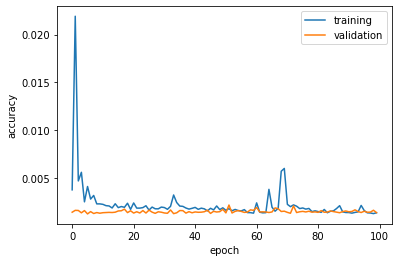

In [25]:
model1 = tfanalysis("GrowthStock_PercentChange", ["inflation5yr_PercentChange"], 0.3)[1]

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 1s 18ms/sample - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 2/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0419 - val_mean_squared_error: 0.0419
Epoch 3/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 5/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0107 - val_mean

80/80 [==============================] - 0s 5ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 51/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 52/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 53/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 54/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 55/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 56/100
80/80 [=========

80/80 [==============================] - 1s 7ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
0.054260064


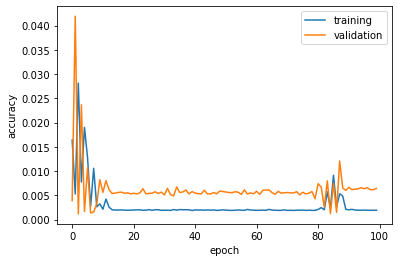

In [26]:
model2 = tfanalysis("ValueStock_PercentChange", ["inflation5yr_PercentChange"], 0.3)[1]

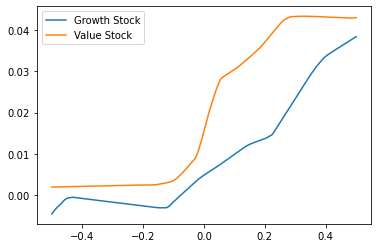

In [28]:
testing_data = np.linspace(-0.5,0.5,200)
growth_change = model1.predict(testing_data)
value_change = model2.predict(testing_data)
plt.plot(testing_data, growth_change, label = "Growth Stock")
plt.plot(testing_data, value_change, label = "Value Stock")
plt.legend()

#### CPI Percentage Change

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 1s 19ms/sample - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 2/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 3/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 4/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 5/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0600 - val_mean_squared_error: 0.0600
Epoch 6/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0308 - val_mean

Epoch 51/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.1052 - val_mean_squared_error: 0.1052
Epoch 52/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0872 - val_mean_squared_error: 0.0872
Epoch 53/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 54/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 55/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 56/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 57/100
80/

0.04670899


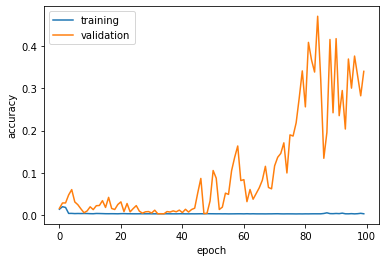

In [31]:
model3 = tfanalysis("GrowthStock_PercentChange", ["CPI_PercentChange"], 0.3)[1]

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 2s 19ms/sample - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 2/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 3/100
80/80 [==============================] - 1s 8ms/sample - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 4/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 5/100
80/80 [==============================] - 1s 8ms/sample - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 6/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0067 - val_mean

Epoch 51/100
80/80 [==============================] - 1s 9ms/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 52/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 53/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 54/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 55/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 56/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 57/100
80/

0.34804413


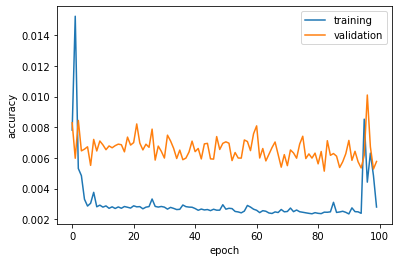

In [32]:
model4 = tfanalysis("ValueStock_PercentChange", ["CPI_PercentChange"], 0.3)[1]

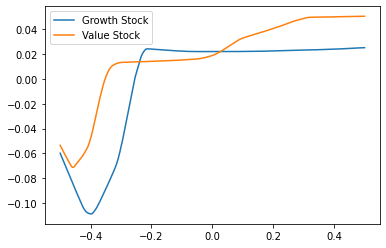

In [33]:
testing_data = np.linspace(-0.5,0.5,200)
growth_change = model3.predict(testing_data)
value_change = model4.predict(testing_data)
plt.plot(testing_data, growth_change, label = "Growth Stock")
plt.plot(testing_data, value_change, label = "Value Stock")
plt.legend()

#### Exchange Percentage Difference

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 3s 36ms/sample - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/100
80/80 [==============================] - 1s 6ms/sample - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/100
80/80 [==============================] - 1s 9ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 5/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0021 - val_mean

Epoch 51/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 52/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 53/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 54/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 55/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 56/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 57/100
80/

0.055787954


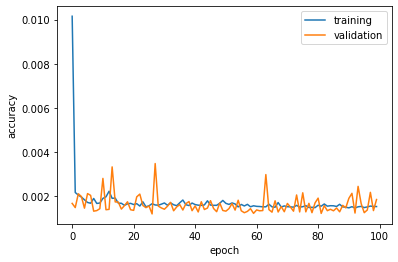

In [38]:
model5 = tfanalysis("GrowthStock_PercentChange", ["exchange_PercentChange"], 0.3)[1]

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 1s 14ms/sample - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 3/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0018 - val_mean

Epoch 51/100
80/80 [==============================] - 1s 16ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 52/100
80/80 [==============================] - 2s 25ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 53/100
80/80 [==============================] - 2s 21ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 54/100
80/80 [==============================] - 1s 14ms/sample - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 55/100
80/80 [==============================] - 2s 28ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 56/100
80/80 [==============================] - 3s 34ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 57/1

0.0356627


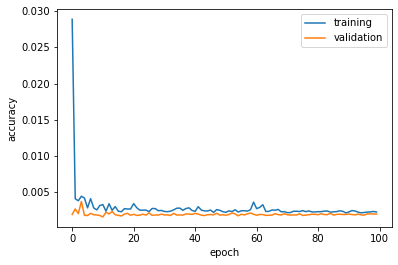

In [39]:
model6 = tfanalysis("ValueStock_PercentChange", ["exchange_PercentChange"], 0.3)[1]

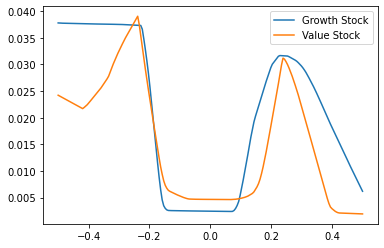

In [40]:
testing_data = np.linspace(-0.5,0.5,200)
growth_change = model5.predict(testing_data)
value_change = model6.predict(testing_data)
plt.plot(testing_data, growth_change, label = "Growth Stock")
plt.plot(testing_data, value_change, label = "Value Stock")
plt.legend()

#### 10 Year Treasury Yield

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 2s 25ms/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/100
80/80 [==============================] - 1s 8ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 6/100
80/80 [==============================] - 1s 9ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0011 - val_mean

80/80 [==============================] - 0s 6ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 51/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 52/100
80/80 [==============================] - 1s 6ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 53/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 54/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 55/100
80/80 [==============================] - 1s 6ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 56/100
80/80 [=========

80/80 [==============================] - 0s 4ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
0.06463183


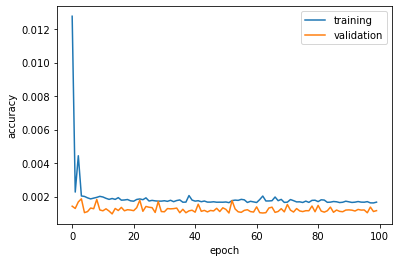

In [42]:
model7 = tfanalysis("GrowthStock_PercentChange", ["Treasury10yr_PercentChange"], 0.3)[1]

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 1s 17ms/sample - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/100
80/80 [==============================] - 1s 7ms/sample - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/100
80/80 [==============================] - 1s 11ms/sample - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 9.5522e-04 - val_mean_squared_error: 9.5522e-04
Epoch 6/100
80/80 [==============================] - 1s 11ms/sample - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0020 

80/80 [==============================] - 0s 4ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 51/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 52/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 53/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 54/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 55/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 56/100
80/80 [=========

Epoch 100/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
0.043758325


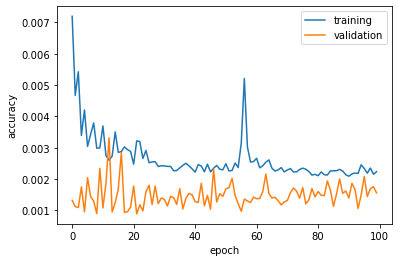

In [43]:
model8 = tfanalysis("ValueStock_PercentChange", ["Treasury10yr_PercentChange"], 0.3)[1]

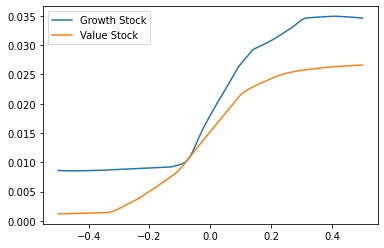

In [45]:
testing_data = np.linspace(-0.5,0.5,200)
growth_change = model7.predict(testing_data)
value_change = model8.predict(testing_data)
plt.plot(testing_data, growth_change, label = "Growth Stock")
plt.plot(testing_data, value_change, label = "Value Stock")
plt.legend()

## Step 4: Visualization

In [62]:
testing_data = np.linspace(-0.5, 0.5, 1000)

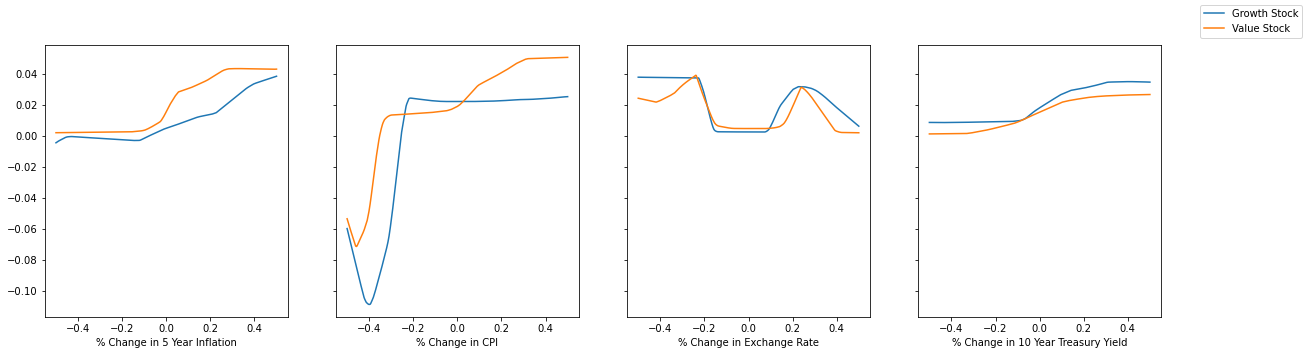

In [72]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5), sharey = True)
ax[0].plot(testing_data, model1.predict(testing_data), label = "Growth Stock")
ax[0].plot(testing_data, model2.predict(testing_data), label = "Value Stock")
ax[0].set_xlabel('% Change in 5 Year Inflation')
ax[1].plot(testing_data, model3.predict(testing_data))
ax[1].plot(testing_data, model4.predict(testing_data))
ax[1].set_xlabel('% Change in CPI')
ax[2].plot(testing_data, model5.predict(testing_data))
ax[2].plot(testing_data, model6.predict(testing_data))
ax[2].set_xlabel('% Change in Exchange Rate')
ax[3].plot(testing_data, model7.predict(testing_data))
ax[3].plot(testing_data, model8.predict(testing_data))
ax[3].set_xlabel('% Change in 10 Year Treasury Yield')
fig.legend()